In [1]:
import deepSI_jax
from deepSI_jax import get_nu_ny_and_auto_norm
from deepSI_jax.utils import NRMS_error
import numpy as np

# Data generation
To illustrate different loss function options, we generate a similar data-set as in example 1.

In [2]:
# Generate or load data
np.random.seed(0)  # for reproducibility
U = np.random.randn(10000)  # Input sequence
x = [0, 0]  # Initial state
ylist = []  # Output sequence
for uk in U:
    ek = np.random.normal(loc=0, scale=0.05)
    ylist.append(x[0] + ek)  # Compute output
    x = x[0] / (1.2 + x[1]**2) + x[1] * 0.4, \
        x[1] / (1.2 + x[0]**2) + x[0] * 0.4 + uk  # Advance state
Y = np.array(ylist)  # Output sequence

# Split datasets
Y_train = Y[:9000]
Y_test = Y[9000:]
U_train = U[:9000]
U_test = U[9000:]

# Model creation
First, we create a similar model as in example 1.

In [3]:
nu, ny, norm = get_nu_ny_and_auto_norm(Y_train, U_train)
nx = 3
f_dict = dict(hidden_layers=2, nodes_per_layer=32, activation='tanh')
h_dict = dict(feedthrough=False)
model = deepSI_jax.SUBNET(nx=nx, ny=ny, nu=nu, norm=norm, f_args=f_dict, h_args=h_dict, use_encoder=False, seed=3)

# Cost function selection
But now, instead of applying the simulation loss function, we specify the truncated prediction loss. This divides the training set into various (overlapping) subsections and computes the error of the simulated model output on each section separately, then uses the average error value as the cost for optimization.

To apply this option, simply define `T` when calling the `set_loss_fun` method. `T` denotes the length of the subsections, i.e., the truncation length. It is also possible to provide `T_overlap`, which stands for the length of the overlap between each section.

Keep in mind that since now the initial state of each subsection is co-estimated with the model parameters:
- the number of optimized variables grows with the number of applied subsections.
- Regularization of all initial state values might not be beneficial.

In [4]:
model.set_loss_fun(T=250, T_overlap=50, l2_reg=1e-4)

# Model training (no encoder)

In [5]:
model.optimization(adam_epochs=200, lbfgs_epochs=200)  # only to run fast
# model.optimization(adam_epochs=1000, lbfgs_epochs=5000, iprint=0)  # uncomment this for better results

# Train model on data
model.fit(Y_train, U_train)

t0 = model.t_solve
print(f"Elapsed time: {t0} s")

  0%|                        |


Solving NLP with Adam (1818 optimization variables) ...



  0%|                        |5210, |grad f| =  2.724172, iter = 1
    f =   0.988669, f* =  0.988669, |grad f| =  2.421837, iter = 2
    f =   0.974028, f* =  0.974028, |grad f| =  2.175327, iter = 3
  2%|▍                       |0942, |grad f| =  1.975592, iter = 4
    f =   0.949039, f* =  0.949039, |grad f| =  1.822083, iter = 5
    f =   0.937989, f* =  0.937989, |grad f| =  1.713480, iter = 6
  4%|▊                       |7519, |grad f| =  1.663321, iter = 7
    f =   0.917384, f* =  0.917384, |grad f| =  1.722159, iter = 8
    f =   0.907366, f* =  0.907366, |grad f| =  1.815104, iter = 9
  5%|█▏                      |7279, |grad f| =  1.898616, iter = 10
    f =   0.886975, f* =  0.886975, |grad f| =  1.970485, iter = 11
    f =   0.876345, f* =  0.876345, |grad f| =  2.031760, iter = 12
  6%|█▌                      |5299, |grad f| =  2.084897, iter = 13
    f =   0.853756, f* =  0.853756, |grad f| =  2.132933, iter = 14
    f =   0.841637, f* =  0.841637, |grad f| =  2.179078

Solving NLP with L-BFGS (1818 optimization variables) ...
L-BFGS-B done in 175 iterations.
Elapsed time: 17.53656029701233 s


# Introducing the encoder network
If the number of applied subsections is really large, then optimizing the initial state values of each subsection requires introducing $N_\mathrm{sec} n_x$ new optimization variables, where $n_\mathrm{sec}$ is the number of subsections. For large $N_\mathrm{sec}$ values, this might cause suboptimal performance in terms of training speed and model accuracy. A possible solution is to introduce an encoder network into the model structure that estimates the initial states based on $n$ number of past IO data pairs. This modification can be easily implemented in `deepSI-jax`. First, during model initialization, the `use_encoder` flag needs to be set as `True` (which is the default value) and the encoder lag `n` also needs to be provided. For specifying the structure of the encoder ANN, similar dictionaries can be defined as for the $f$ and $h$ functions.

In [6]:
encoder_dict = dict(hidden_layers=2, nodes_per_layer=16, activation='swish')
n_lag = 20
model_with_encoder = deepSI_jax.SUBNET(nx=nx, ny=ny, nu=nu, norm=norm, f_args=f_dict, h_args=h_dict, use_encoder=True, encoder_args=encoder_dict, encoder_lag=n_lag, seed=3)

For the loss function and optimization algorithm settings, the same principles can be followed as previously. Keep in mind that utilizing an encoder network is only possible if the truncated prediction loss is applied (i.e., `T` is defined when calling `set_loss_fun`).

In [7]:
model_with_encoder.set_loss_fun(T=250, T_overlap=50, l2_reg=1e-4)
model_with_encoder.optimization(adam_epochs=200, lbfgs_epochs=200)  # only to run fast
# model_with_encoder.optimization(adam_epochs=1000, lbfgs_epochs=5000, iprint=0)  # uncomment this for better results

# Train model on data
model_with_encoder.fit(Y_train, U_train)

t0 = model_with_encoder.t_solve
print(f"Elapsed time: {t0} s")

  0%|                        |


Solving NLP with Adam (2782 optimization variables) ...



  0%|                        |6695, |grad f| =  2.522073, iter = 1
    f =   0.991038, f* =  0.991038, |grad f| =  2.236257, iter = 2
    f =   0.977196, f* =  0.977196, |grad f| =  2.015182, iter = 3
  2%|▍                       |4679, |grad f| =  1.849383, iter = 4
    f =   0.953106, f* =  0.953106, |grad f| =  1.730270, iter = 5
    f =   0.942210, f* =  0.942210, |grad f| =  1.655935, iter = 6
  4%|▊                       |1759, |grad f| =  1.654134, iter = 7
    f =   0.921541, f* =  0.921541, |grad f| =  1.733336, iter = 8
    f =   0.911366, f* =  0.911366, |grad f| =  1.815235, iter = 9
    f =   0.901072, f* =  0.901072, |grad f| =  1.888857, iter = 10
  6%|█▎                      |0529, |grad f| =  1.954226, iter = 11
    f =   0.879631, f* =  0.879631, |grad f| =  2.012978, iter = 12
    f =   0.868279, f* =  0.868279, |grad f| =  2.067652, iter = 13
  7%|█▋                      |6378, |grad f| =  2.121079, iter = 14
    f =   0.843835, f* =  0.843835, |grad f| =  2.177422

Solving NLP with L-BFGS (2782 optimization variables) ...
L-BFGS-B done in 175 iterations.
Elapsed time: 14.697416067123413 s


# Simulation on test data
When no encoder network is applied, the same process is used as described in example 1. However, when an encoder network is co-estimated with the ANN_SS model, estimating the initial state of the test data is much simpler, as the encoder network can be directly used for this purpose.

First, we simulate the model that does not contain an encoder. For a fair comparison, we use the same state initialization window as the encoder lag.

In [8]:
x0_test = model.learn_x0(U_test[:n_lag], Y_test[:n_lag], RTS_epochs=10, LBFGS_refinement=True, verbosity=False)
Yhat_test_no_enc, _ = model.simulate(x0_test, U_test)
nrmse_no_enc = NRMS_error(Y_test[n_lag:], Yhat_test_no_enc[n_lag:, 0])  # we only compute errors after the state init. window

Then, with the encoder, we can simply call the `model.encoder_estim_x0` method for estimating the initial state.

In [9]:
x0_test = model_with_encoder.encoder_estim_x0(Y_test[:n_lag], U_test[:n_lag])
Yhat_test_w_enc, _ = model_with_encoder.simulate(x0_test, U_test[n_lag:])  # keep in mind that now we will only simulate from time index n_lag
nrmse_w_enc = NRMS_error(Y_test[n_lag:], Yhat_test_w_enc)

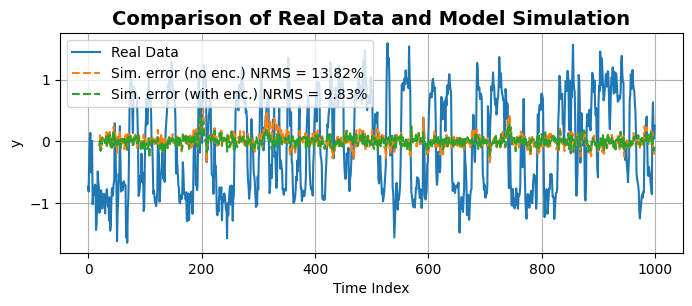

In [10]:
sim_idx = np.arange(U_test.shape[0])
# Visualize simulation of the model
from matplotlib import pyplot as plt
plt.figure(figsize=(7,3))
plt.plot(sim_idx, Y_test, label='Real Data')
plt.plot(sim_idx[n_lag:], Y_test[n_lag:] - Yhat_test_no_enc[n_lag:, 0], label=f'Sim. error (no enc.) NRMS = {nrmse_no_enc:.2%}', linestyle='--')
plt.plot(sim_idx[n_lag:], Y_test[n_lag:] - Yhat_test_w_enc[:, 0], label=f'Sim. error (with enc.) NRMS = {nrmse_w_enc:.2%}', linestyle='--')
plt.title('Comparison of Real Data and Model Simulation', fontsize=14, fontweight='bold')
plt.legend(); plt.xlabel('Time Index'); plt.ylabel('y'); plt.grid(); plt.tight_layout(pad=0.5)
plt.show()